# Topic modelling for InnerSpeech dataset (Japanese)


Author : Romy Beauté\
Date created : 02/12/2024\
Last modified : 24/02/2025\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



In [37]:
%%capture
# !pip install bertopic accelerate bitsandbytes xformers adjustText
# !pip install llama-cpp-python
# !{sys.executable} -m pip install "scipy==1.9.0" "scikit-image==0.23.2"

import os
import nltk
import sys
import pandas as pd
import numpy as np
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

#personal imports
from multiling_helpers import JapaneseProcessor, TopicModeler

# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------

project = "multilingual"
dataset = "innerspeech_japanese" 
language = "japanese"


# Prepare data

In [ ]:
print(os.getcwd())

MOSAIC_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # go up one level
print("MOSAIC directory:", MOSAIC_dir)


# ------------------------------------------------------------------------------------------------

DATA_dir = os.path.join(MOSAIC_dir, f'DATA/{project}')
print("DATA directory:", DATA_dir)

# ------------------------------------------------------------------------------------------------

sentences = True
reduced_GS = False
random_seed = 42
nr_topics = "auto" 
reports_path = os.path.join(DATA_dir,f"{dataset}.xlsx")
df = pd.read_excel(reports_path)


# ------------------------------------------------------------------------------------------------
colnames = pd.read_excel(reports_path).columns.tolist()
print(len(colnames), "columns:", colnames)

non_numeric_cols = df.select_dtypes(exclude=['int64', 'float64']).columns
print(f"Columns with non-numeric values (n={len(non_numeric_cols.tolist())}):", non_numeric_cols.tolist())

/Users/rbeaute/Projects/MOSAIC/MULTILINGUAL
MOSAIC directory: /Users/rbeaute/Projects/MOSAIC
DATA directory: /Users/rbeaute/Projects/MOSAIC/DATA/multilingual
38 columns: ['タイムスタンプ', '性別（自認）を教えて下さい', '年齢を教えて下さい', '上の動画がどれだけ自分の内言として当てはまりますか？', '上の動画がどれだけ自分の内言として当てはまりますか？.1', '上の動画がどれだけ自分の内言として当てはまりますか？.2', '上の動画がどれだけ自分の内言として当てはまりますか？.3', '上の動画がどれだけ自分の内言として当てはまりますか？.4', '上の動画がどれだけ自分の内言として当てはまりますか？.5', '上の動画がどれだけ自分の内言として当てはまりますか？.6', '上記とは異なる内言で思考している場合は教えて下さい（任意）', '上の動画がどれだけ自分の内言として当てはまりますか？.7', '上の動画がどれだけ自分の内言として当てはまりますか？.8', '上の動画がどれだけ自分の内言として当てはまりますか？.9', '上の動画がどれだけ自分の内言として当てはまりますか？.10', '上の動画がどれだけ自分の内言として当てはまりますか？.11', '上の動画がどれだけ自分の内言として当てはまりますか？.12', '上の動画がどれだけ自分の内言として当てはまりますか？.13', '上記とは異なる内言で思考している場合は教えて下さい（任意）.1', '上の動画がどれだけ自分の内言として当てはまりますか？.14', '上の動画がどれだけ自分の内言として当てはまりますか？.15', '上の動画がどれだけ自分の内言として当てはまりますか？.16', '上の動画がどれだけ自分の内言として当てはまりますか？.17', '上の動画がどれだけ自分の内言として当てはまりますか？.18', '上の動画がどれだけ自分の内言として当てはまりますか？.19', '上の動画がどれだけ自分の内言として当てはまりますか？.20', '上記とは異なる内言で思考している場合は教えて下さい（任意）.2', '内言の

non-numeric columns translated:

1. Timestamp
2. Gender (self-identified)
3. Age
4. If you think in different inner speech than above, please tell us (optional)
5. If you think in different inner speech than above, please tell us (optional).1
6. If you think in different inner speech than above, please tell us (optional).2
7. Please freely describe anything else about inner speech (optional)

### Isolate non-numeric variables (that might contain verbal reports)

In [9]:
# create dataframe of non-numeric columns
df_non_numeric = df[non_numeric_cols]
df_non_numeric.head(5)

,タイムスタンプ,性別（自認）を教えて下さい,年齢を教えて下さい,上記とは異なる内言で思考している場合は教えて下さい（任意）,上記とは異なる内言で思考している場合は教えて下さい（任意）.1,上記とは異なる内言で思考している場合は教えて下さい（任意）.2,内言について他に述べたいことがあれば自由に記述してください（任意）
0,2022-05-11 17:46:55.621,男性,35,NaN,NaN,NaN,NaN
1,2022-05-11 17:48:16.588,男性,26,NaN,NaN,NaN,NaN
2,2022-05-11 17:49:03.556,女性,21,NaN,NaN,NaN,NaN
3,2022-05-11 17:49:33.625,男性,34,NaN,NaN,NaN,NaN
4,2022-05-11 17:49:48.730,女性,53,NaN,NaN,NaN,NaN


non-numeric columns translated:

1. If you think in different inner speech than above, please tell us (optional)
2. If you think in different inner speech than above, please tell us (optional).1
3. If you think in different inner speech than above, please tell us (optional).2
4. Please freely describe anything else about inner speech (optional)


Participants were asked several questions in 3 different situations.
The situations were illustrated with videos: 
- A situation where you are looking for your wallet
- A situation where you are thinking about buying a car
- A situation where you are thinking about lunch
After they rated videos which explain different types of inner speech, the following question was asked:\
**Question: "If you are thinking in a different way, please write it down (optional)"**

In [10]:
#remove non_numeric_cols[0], non_numeric_cols[1], non_numeric_cols[2] from df_non_numeric
df_non_numeric = df_non_numeric.drop(columns=[non_numeric_cols[0], non_numeric_cols[1], non_numeric_cols[2]])


#remove all participants that have NaN in all columns from df_non_numeric
print(len(df_non_numeric)) #before removing NaNs
df_non_numeric = df_non_numeric.dropna(how='all')
print(len(df_non_numeric)) #after removing NaNs


# ------------------------------------------------------------------------------------------------
#update non_numeric_cols to reflect the removal of non_numeric_cols[0], non_numeric_cols[1], non_numeric_cols[2]
non_numeric_cols = df_non_numeric.columns
#remane text reports cols for clarity:
df_non_numeric = df_non_numeric.rename(columns={non_numeric_cols[0]: 'wallet_answer'})
df_non_numeric = df_non_numeric.rename(columns={non_numeric_cols[1]: 'car_answer'})
df_non_numeric = df_non_numeric.rename(columns={non_numeric_cols[2]: 'lunch_answer'})
df_non_numeric = df_non_numeric.rename(columns={non_numeric_cols[3]: 'reflection_answer'})

df_non_numeric.head(5)

5365
1313


,wallet_answer,car_answer,lunch_answer,reflection_answer
5,NaN,NaN,NaN,頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り...
11,自分の動きを考えるときは、漫画のネームみたいな感じで思い浮かべる,NaN,NaN,NaN
14,NaN,NaN,味と匂いを想像し、それをいま自分が欲しているのかを自らに問う,他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラ...
24,基本は回答した通り映像なんですが、そこに自分が財布を置いた時、触った時の体の感覚も入ってる感じです,NaN,イメージと自分の言葉に加えて、食べたいかどうかを味を想像して考えてる気がします,NaN
26,NaN,NaN,音声と文字のどちらかだけではなく、組み合わさっていると思う。,頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字...


In [11]:
#list of reflection_answer, and remove NaN values
wallet_reports = df_non_numeric['wallet_answer'].dropna()
car_reports = df_non_numeric['car_answer'].dropna()
lunch_reports = df_non_numeric['lunch_answer'].dropna()
df_reports = df_non_numeric['reflection_answer'].dropna()

all_reports = pd.concat([wallet_reports, car_reports, lunch_reports, df_reports])
print(f"N = {len(all_reports)} reports in total")
all_reports.head(5)

#convert to list 
all_reports = all_reports.tolist()

N = 1979 reports in total


# Topic Modelling

In [12]:
# Initialize Japanese processor and topic modeler
japanese_processor = JapaneseProcessor()
#print the infos about the processor for japanese
japanese_processor.print_info()

japanese_processor.sentence_transformer_model = "paraphrase-multilingual-mpnet-base-v2"
japanese_modeler = TopicModeler(japanese_processor) #iniy modeler with modified processor

Please install MeCab: pip install mecab-python3 unidic-lite
Language: japanese
Transformer model: bge-multilingual-gemma2
Number of stopwords: 0
Sentence endings: {'.', '．', '!', '。', '？', '?', '\n', '！'}


In [13]:
# Preprocess and split into sentences
print(f"Processing {len(all_reports)} {language} reports...")
processed_data = japanese_modeler.process_data(all_reports, split_sentences=True)
print(f"Processed into {len(processed_data)} sentences.")
# Prepare vectorizer
vectorizer = japanese_modeler.prepare_vectorizer()

# Get embeddings
embeddings = japanese_modeler.embedding_model.encode(processed_data, show_progress_bar=True)

Processing 1979 japanese reports...
Processed into 3730 sentences.


Batches:   0%|          | 0/117 [00:00<?, ?it/s]

### BERTopic

In [14]:
#set up UMAP and HDBSCAN for topic modelling
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

umap_model = UMAP(
    n_neighbors=15,
    n_components=3,
    min_dist=0.01,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=20,
    min_samples=None,
    gen_min_span_tree=True,
    prediction_data=True
)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    language="japanese",
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(processed_data, embeddings)

2025-02-24 15:08:47,173 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-24 15:09:04,917 - BERTopic - Dimensionality - Completed ✓
2025-02-24 15:09:04,918 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-24 15:09:05,101 - BERTopic - Cluster - Completed ✓
2025-02-24 15:09:05,103 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-24 15:09:05,126 - BERTopic - Representation - Completed ✓


In [15]:
# Get topic info
topic_info = topic_model.get_topic_info()
print("Number of topics found:", len(topic_info)-1)  # -1 to exclude outlier topic
print("\nTop topics by size:")
print(topic_info.head())

# Get top words for each topic
for topic in topic_info.Topic:
    if topic != -1:  # Skip outlier topic
        print(f"\nTopic {topic}:")
        print(topic_model.get_topic(topic))

Number of topics found: 26

Top topics by size:
   Topic  Count                           Name  \
0     -1   1490        -1_ありがとうございました_また_内言_文字   
1      0    419           0_ラーメン_食べたいもの_パスタ_触覚   
2      1    219  1_映像_映像と音声_頭の中で自分の声で思考する_自分の声   
3      2    197          2_自分の声_その_また_ささやき声に近い   
4      3    182            3_あそこか_です_と思いました_あれ   

                                      Representation  \
0  [ありがとうございました, また, 内言, 文字, という感じです, しかし, 発想, 視覚...   
1  [ラーメン, 食べたいもの, パスタ, 触覚, うどん, ではなく, 思い出す, 視覚, 映...   
2  [映像, 映像と音声, 頭の中で自分の声で思考する, 自分の声, 自分の音声, 映像 自分の...   
3  [自分の声, その, また, ささやき声に近い, 自分の声です, うまく言えませんが, その...   
4  [あそこか, です, と思いました, あれ, という感覚があります, それぞれの, が浮かぶ...   

                                 Representative_Docs  
0            [ありがとうございました, ありがとうございました, ありがとうございました]  
1  [言葉は「カレー」とか「ラーメン」とか程度, ラーメン……, 頭の中に文章ではなく単語（「パ...  
2  [自分の声＆自分の声で掛け合い＆映像＆BGM, 映像（短い動画・静止映像）もぼんやり映ります...  
3  [自分の声……, ただ、その“声”が自分のものか他人のものか考えたことはなく、考えれば考える...  
4                   [あそこか, 「んーーーどこかだったか

In [26]:
topic_info = topic_model.get_topic_info()
topic_info.Name

0                               -1_ありがとうございました_また_内言_文字
1                                  0_ラーメン_食べたいもの_パスタ_触覚
2                         1_映像_映像と音声_頭の中で自分の声で思考する_自分の声
3                                 2_自分の声_その_また_ささやき声に近い
4                                   3_あそこか_です_と思いました_あれ
5                         4_財布_机の上_頭の中で映像で思考する_どこに置いたかな
6                          5_写真_全体的に_ではなく静止画で思考する_映像 写真
7             6_面白かったです_頑張ってください_ありがとうございます_ありがとうございました
8                                7_貯金_必要性_みたいな感じです_のような
9                                   8_自分_あと_自分b_に近いのですが
10                                    9_内言_状況_内言について_今回
11    10_他人の声で聞こえる_聞こえた言葉を文字として認識していて_それに対する答えを自分の声で...
12                                   11_正直_私の場合は_独り言_また
13                        12_ものを考えるとき_t1_動画_頭の中で映像で思考する
14                              13_うまく言えませんが_雰囲気_におい_内言
15                                               14____
16    15_頭の中に自分と他者がおり対話することで思考する_頭の中に自分がおりその自分が一人で対話...
17                                            16

In [ ]:


for index, row in topic_info.iterrows():
    if row['Topic'] != -1:  # Skip the outlier topic
        print(f"Topic {row['Topic']}: {row['Name']}")
        print(f"Representation: {row['Representation']}\n")

Topic 0: 0_ラーメン_食べたいもの_パスタ_触覚
Representation: ['ラーメン', '食べたいもの', 'パスタ', '触覚', 'うどん', 'ではなく', '思い出す', '視覚', '映像', '自分の声で思考しながら']

Topic 1: 1_映像_映像と音声_頭の中で自分の声で思考する_自分の声
Representation: ['映像', '映像と音声', '頭の中で自分の声で思考する', '自分の声', '自分の音声', '映像 自分の声', '頭の中で映像で思考する', '自分の声どうしで対話している', '自分の声で思考しながら', 'ああ']

Topic 2: 2_自分の声_その_また_ささやき声に近い
Representation: ['自分の声', 'その', 'また', 'ささやき声に近い', '自分の声です', 'うまく言えませんが', 'その間', 'ああ', 'えー', '複数人']

Topic 3: 3_あそこか_です_と思いました_あれ
Representation: ['あそこか', 'です', 'と思いました', 'あれ', 'という感覚があります', 'それぞれの', 'が浮かぶ', 'みたいな', '全体的に', '状況']

Topic 4: 4_財布_机の上_頭の中で映像で思考する_どこに置いたかな
Representation: ['財布', '机の上', '頭の中で映像で思考する', 'どこに置いたかな', '同時に', '鞄の中', '画像', 'など', '映画', '映像で']

Topic 5: 5_写真_全体的に_ではなく静止画で思考する_映像 写真
Representation: ['写真', '全体的に', 'ではなく静止画で思考する', '映像 写真', '時々', '思考のうち', '単語化', '動画 ではなく静止画で思考する', '上記の', '映像 動画']

Topic 6: 6_面白かったです_頑張ってください_ありがとうございます_ありがとうございました
Representation: ['面白かったです', '頑張ってください', 'ありがとうございます', 'ありがとうございました', '', '', '', '', '', '']

Topic 7

In [17]:
topic_model.visualize_barchart()


In [28]:
#remove topic -1 (outlier)
topic_info = topic_info[topic_info['Topic'] != -1]
topic_info = topic_info.reset_index(drop=True)
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,0,419,0_ラーメン_食べたいもの_パスタ_触覚,"[ラーメン, 食べたいもの, パスタ, 触覚, うどん, ではなく, 思い出す, 視覚, 映...","[言葉は「カレー」とか「ラーメン」とか程度, ラーメン……, 頭の中に文章ではなく単語（「パ..."
1,1,219,1_映像_映像と音声_頭の中で自分の声で思考する_自分の声,"[映像, 映像と音声, 頭の中で自分の声で思考する, 自分の声, 自分の音声, 映像 自分の...","[自分の声＆自分の声で掛け合い＆映像＆BGM, 映像（短い動画・静止映像）もぼんやり映ります..."
2,2,197,2_自分の声_その_また_ささやき声に近い,"[自分の声, その, また, ささやき声に近い, 自分の声です, うまく言えませんが, その...","[自分の声……, ただ、その“声”が自分のものか他人のものか考えたことはなく、考えれば考える..."
3,3,182,3_あそこか_です_と思いました_あれ,"[あそこか, です, と思いました, あれ, という感覚があります, それぞれの, が浮かぶ...","[あそこか, 「んーーーどこかだったかな、あそこか, あそこか]"
4,4,180,4_財布_机の上_頭の中で映像で思考する_どこに置いたかな,"[財布, 机の上, 頭の中で映像で思考する, どこに置いたかな, 同時に, 鞄の中, 画像,...","[この場合は、財布、机、鞄のように, 財布、えっと鞄の中だっけ…, 財布…]"
5,5,111,5_写真_全体的に_ではなく静止画で思考する_映像 写真,"[写真, 全体的に, ではなく静止画で思考する, 映像 写真, 時々, 思考のうち, 単語化...","[映像（動画）ではなく静止画で思考する, をつなぐような大きな動きとして、想像の空間に概念の..."
6,6,96,6_面白かったです_頑張ってください_ありがとうございます_ありがとうございました,"[面白かったです, 頑張ってください, ありがとうございます, ありがとうございました, ,...","[面白かったです, 面白かったです, 面白かったです]"
7,7,94,7_貯金_必要性_みたいな感じです_のような,"[貯金, 必要性, みたいな感じです, のような, うーん, 私は, イメージ, 頭の中で,...",[フローチャートではなく、自分の声によって、車を買った時と買わなかった時の様々なメリットデメ...
8,8,72,8_自分_あと_自分b_に近いのですが,"[自分, あと, 自分b, に近いのですが, だが, という感覚です, そして, なので, ...",[もちろん、全登場人物に「自分」感がないけれど行動変化可能性感があるような空想、というのもあ...
9,9,71,9_内言_状況_内言について_今回,"[内言, 状況, 内言について, 今回, と思いました, 面白かったです, 視覚, なので,...","[「内言」という言葉は初めて聞いた, 「内言」という言葉は初めて知りました, 「内言」という..."


In [29]:
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.01, random_state=42).fit_transform(embeddings)
topic_model.visualize_documents(
    docs=processed_data,
    reduced_embeddings=reduced_embeddings  # Pass reduced embeddings
)

In [ ]:


# !pip install mecab-python3 unidic-lite
# import MeCab
# wakati = MeCab.Tagger("-Owakati")

In [30]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

sentence_transformer_model = "all-mpnet-base-v2" #"paraphrase-MiniLM-L6-v2"# #"BAAI/bge-small-en" "all-MiniLM-L6-v2'"
embedding_model = SentenceTransformer(sentence_transformer_model)
embeddings = embedding_model.encode(all_reports, show_progress_bar=True)
print(embedding_model)

# vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words=list(stopwords.words('japanese')),max_df=0.9,min_df=2)#+list(reduced_custom_stopwords)) #ngram_range=(1,2) : unigrams and bigrams
vectorizer_model = CountVectorizer(ngram_range=(1,2),max_df=0.9,min_df=2)#+list(reduced_custom_stopwords)) #ngram_range=(1,2) : unigrams and bigrams

# n_neighbors = int(chosen_params['n_neighbors'])
# n_components = int(chosen_params['n_components'])
# min_dist = float(chosen_params['min_dist'])
# min_cluster_size = int(chosen_params['min_cluster_size'])
# min_samples= int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
# top_n_words = int(chosen_params['top_n_words'])
# nr_topics = "auto"

n_neighbors = 15# int(chosen_params['n_neighbors'])
n_components = 3 #int(chosen_params['n_components'])
min_dist = 0.01 #float(chosen_params['min_dist'])
min_cluster_size = 10# int(chosen_params['min_cluster_size'])
min_samples= None #int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
top_n_words = 10 #int(chosen_params['top_n_words'])
nr_topics = "auto"



metric='cosine'

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [31]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine', random_state=random_seed).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=n_neighbors,
                  n_components=n_components,
                  min_dist=min_dist,
                  metric=metric,
                  random_state=random_seed) # rdm seed for reportability

hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        # cluster_selection_epsilon=0.3,
                        gen_min_span_tree=True,
                        prediction_data=True)


In [34]:
os.getcwd()

'/Users/rbeaute/Projects/MOSAIC/MULTILINGUAL'

In [35]:
src_path = os.path.join(MOSAIC_dir, "src")
sys.path.insert(0, src_path)

from utils import calculate_coherence

In [44]:
model = BERTopic(
    umap_model=umap_model,
    low_memory=True,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=top_n_words,
    nr_topics= nr_topics,#default to None
    language='japanese',
    calculate_probabilities=True,
    verbose=True)

topics,_ = model.fit_transform(all_reports)

coherence_score,coherence_score_umass = calculate_coherence(model, all_reports) #sanitary check for coherence, that we obtain the same score as when running GS
print("Coherence Score:", coherence_score)

print(f"n = {len(np.unique(topics))} topics extracted")


#check how many documents identified as outliers
print(len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1]))

2025-02-24 16:01:33,175 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-02-24 16:01:48,057 - BERTopic - Embedding - Completed ✓
2025-02-24 16:01:48,058 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-24 16:01:52,963 - BERTopic - Dimensionality - Completed ✓
2025-02-24 16:01:52,964 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-24 16:01:53,064 - BERTopic - Cluster - Completed ✓
2025-02-24 16:01:53,065 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-24 16:01:53,096 - BERTopic - Representation - Completed ✓
2025-02-24 16:01:53,096 - BERTopic - Topic reduction - Reducing number of topics
2025-02-24 16:01:53,121 - BERTopic - Topic reduction - Reduced number of topics from 30 to 24
2025-02-24 16:01:53,148 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-02-24 16:02:06,822 - BERTopic - Embedding - Completed ✓
2025-02-24 16:02:06,823 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-24 16:02:11,725 - BERTopic - Dimensionality - Completed ✓
2025-02-24 16:02:11,725 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-24 16:02:11,822 - BERTopic - Cluster - Completed ✓
2025-02-24 16:02:11,823 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-24 16:02:11,844 - BERTopic - Representation - Completed ✓
2025-02-24 16:02:11,844 - BERTopic - Topic reduction - Reducing number of topics
2025-02-24 16:02:11,866 - BERTopic - Topic reduction - Reduced number of topics from 30 to 24


Number of valid topics used for coherence calculation: 21
Coherence Score: 0.3162081463603534
n = 24 topics extracted
653


In [45]:
new_topics = model.reduce_outliers(all_reports, topics,strategy='probabilities',probabilities=_,threshold=0.2)

# Check the impact
print(f"Original outliers: {len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")

# #print the sentences that are identified as outliers after reduction
# outliers = np.where(np.array(topics)==-1)[0]
# for i in outliers:
#     print(df_reports[i])

# Verify coherence is maintained
model.topics_ = new_topics
coherence_score, coherence_score_umass = calculate_coherence(model, all_reports)
print(f"New coherence score: {coherence_score:.4f}")

2025-02-24 16:02:30,807 - BERTopic - Embedding - Transforming documents to embeddings.


Original outliers: 653
Remaining outliers after reduction: 653


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-02-24 16:02:44,574 - BERTopic - Embedding - Completed ✓
2025-02-24 16:02:44,574 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-24 16:02:49,452 - BERTopic - Dimensionality - Completed ✓
2025-02-24 16:02:49,452 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-24 16:02:49,551 - BERTopic - Cluster - Completed ✓
2025-02-24 16:02:49,552 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-24 16:02:49,577 - BERTopic - Representation - Completed ✓
2025-02-24 16:02:49,577 - BERTopic - Topic reduction - Reducing number of topics
2025-02-24 16:02:49,599 - BERTopic - Topic reduction - Reduced number of topics from 30 to 24


Number of valid topics used for coherence calculation: 21
New coherence score: 0.3162


In [46]:
# topics = new_topics
_, probabilities = model.transform(all_reports)

print(f"Number of unique topics after update: {len(np.unique([t for t in topics if t != -1]))}")
print(f"Number of remaining outliers: {len([t for t in topics if t == -1])}")


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-02-24 16:03:27,373 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-02-24 16:03:27,384 - BERTopic - Dimensionality - Completed ✓
2025-02-24 16:03:27,384 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-02-24 16:03:27,409 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-02-24 16:03:27,522 - BERTopic - Probabilities - Completed ✓
2025-02-24 16:03:27,523 - BERTopic - Cluster - Completed ✓


Number of unique topics after update: 23
Number of remaining outliers: 653


In [47]:
model.visualize_barchart(title=f'Topic Word Scores for {dataset}',autoscale=True)

In [49]:
model.visualize_documents(all_reports,title=f'Documents and Topics for {dataset}')

# LLAMA 3

In [54]:
!curl -L -o zephyr-7b-alpha.Q4_K_M.gguf https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1129  100  1129    0     0   4701      0 --:--:-- --:--:-- --:--:--  4704
100 4166M  100 4166M    0     0  7616k      0  0:09:20  0:09:19  0:00:01 7607k0  0:15:19  0:00:01  0:15:18 7745k     0  0:09:34  0:00:24  0:09:10 7268k   0  7491k      0  0:09:29  0:00:31  0:08:58 7732k 0  7546k      0  0:09:25  0:00:45  0:08:40 7699k:24  0:00:51  0:08:33 7560k0:09:25  0:01:00  0:08:25 7362k 0  7577k      0  0:09:23  0:01:14  0:08:09 7524k1k582k      0  0:09:22  0:01:34  0:07:48 7595k  0  7580k      0  0:09:22  0:01:44  0:07:38 7442k9k      0  0:09:22  0:01:49  0:07:33 7770k0  0:09:23  0:02:28  0:06:55 7635kk  0:06:08 7913k     0  7618k      0  0:09:19  0:03:24  0:05:55 7942k   0  0:09:19  0:04:00  0:05:19 7767k0  7624k      0  0:09:19  0:04:22  0:04:57 7418k0  0:09:19  0:04:50  0:04:29 7895k    0  7629k      0  0:09:19  0:04:53  0:04:2

In [ ]:
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# !wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf
# oe if not wgwt: !curl -L -o zephyr-7b-alpha.Q4_K_M.gguf https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf


# # DataMapPlot
# !git clone https://github.com/TutteInstitute/datamapplot.git
# !pip install datamapplot/.

import datamapplot
import torch
torch.cuda.empty_cache()



Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple
  Using cached rmm_cu12-24.10.0.tar.gz (13 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [67 lines of output]
      INFO:nvidia-stub:Testing wheel rmm_cu12-24.10.0-cp310-cp310-manylinux_2_24_aarch64.manylinux_2_28_aarch64.whl against tag cp310-cp310-manylinux_2_24_aarch64
      INFO:nvidia-stub:Testing wheel rmm_cu12-24.10.0-cp310-cp310-manylinux_2_24_aarch64.manylinux_2_28_aarch64.whl against tag cp310-cp310-manylinux_2_28_aarch64
      INFO:nvidia-stub:Testing wheel rmm_cu12-24.10.0-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl against tag cp310-cp310-manylinux_2_24_x86_64
      INFO:nvidia-stub:Testing wheel rmm_cu12-24.10.0-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x

In [ ]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper

from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import re  # For regular expressions


#to speed up computation
import torch
torch.cuda.empty_cache()


#add periodic memory clearing (use if too slow to run)
def process_batch(batch):
    results = []
    for item in batch:
        results.append(process_item(item))
        if len(results) % 100 == 0:  # Clear memory every 100 items
            torch.cuda.empty_cache()
    return results


In [58]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename, cache_dir=path)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)

Meta-Llama-3-8B-Instruct-Q4_K_M.gguf:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

In [59]:



prompt = """Q:
Topic documents:
[DOCUMENTS]

Topic keywords: '[KEYWORDS]'

Find the most appropriate scientific label for this topic based on the above information. The label should:

1. Uses Title Case with proper spacing
2. Avoids abstract interpretations
4. Be concise yet comprehensive (2-5 words max)

Only return the label itself, without any additional text or punctuation.
A:
"""

pipeline_kwargs = {
    "max_tokens": 10,      # Default varies
    # Controls maximum length of response
    # 10 is good for 2-3 word labels
    
    "temperature": 0.3,    # conservative to minimise randomness and hallucinations
    
    "top_p": 0.5,         # Default is usually 1.0
    # Range: 0 to 1
    # 0.9: Consider 90% most likely tokens
    # Focus on most probable tokens from the input
    
    "repeat_penalty": 2  # Default is usually 1.0
    # >1.0: Penalize repeated words
    # Useful for avoiding redundant terms in labels
}

representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt,nr_docs=6,pipeline_kwargs=pipeline_kwargs)
}





In [61]:
torch.cuda.empty_cache()

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  nr_topics = nr_topics,
  calculate_probabilities=True,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(all_reports,embeddings)

# Show topics
topic_model.get_topic_info()



2025-02-24 16:41:42,174 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-24 16:41:47,102 - BERTopic - Dimensionality - Completed ✓
2025-02-24 16:41:47,102 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-24 16:41:47,205 - BERTopic - Cluster - Completed ✓
2025-02-24 16:41:47,206 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 30/30 [02:05<00:00,  4.19s/it]
2025-02-24 16:44:04,364 - BERTopic - Representation - Completed ✓
2025-02-24 16:44:04,365 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 24/24 [01:39<00:00,  4.15s/it]
2025-02-24 16:45:52,735 - BERTopic - Topic reduction - Reduced number of topics from 30 to 24


,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,653,-1_内言_映像_自分の声_財布,"[内言, 映像, 自分の声, 財布, あそこか, 頭の中で映像で思考する, また, 陰茎, ...","[自分の声で掛け合い, 自分の音声, 自分の場合は, 自分の声, 未来の自分を想像したり, ...","[Cognitive Mapping\nB: \nMemory and Thought, ,...","[自分の声＆自分の声で掛け合い＆映像＆BGM, フローチャートではなく、自分の声によって、車..."
1,0,352,0_映像_自分の声_内言抜きに無言で思考しているときがある気がします_自分の声と映像,"[映像, 自分の声, 内言抜きに無言で思考しているときがある気がします, 自分の声と映像, ...","[自分の声と映像, 自分と自分の対話, 自分が財布どこかなと喋りながら探している, 自分と対...",[Cognitive Processes\nB: \nThought Patterns\n\...,"[映像+自分の声 のパターンもあり, t2-3「頭の中に自分と他者がおり対話することで思考す..."
2,1,209,1_味覚_写真_食感_映像,"[味覚, 写真, 食感, 映像, 思い出して, 食べたいもの, 嗅覚, また, ではなく, ...","[自分が実際に食べているシーンを想像することが多いです, 自分がその食べ物を食べているところ...","[Cognitive Food Memory\nB: \nFood Imag, , , , ...",[一番最初の質問で答えたのと似ている 映像(写真)と自分の声の組み合わせで思考をする ただし...
3,2,201,2_また_ありがとうございました_ただ_内言,"[また, ありがとうございました, ただ, 内言, たとえば, 例えば, 発想, なので, ...","[自分の場合, 私の場合, 私の場合は, 映像での内言と言葉が聞こえてくるような内言が主であ...",[Cognitive Processes\nB: Thought Patterns Cogn...,[映像化されている作品をテキストで触れる際、頭の中での聞こえ方に違いがあると感じています。\...
4,3,100,3_音でも文字でもない_映像というより絵文字かピクトグラムのようなもので表示されていることも...,"[音でも文字でもない, 映像というより絵文字かピクトグラムのようなもので表示されていることも...","[音でも文字でもない, 映像と文字が複数重なって, 映像でも文字でもなく, 音声でも文字, ...","[Cognitive Processing\nB: \nD:\nE, , , , , , ,...",[映像でも文字でもなく、料理(例ではパスタ・ラーメン・うどん)の概念的なもの？を使って考えて...
5,4,81,4_文章_思念_音声はついていない_文字による文章を黙読するときの頭の中のように,"[文章, 思念, 音声はついていない, 文字による文章を黙読するときの頭の中のように, 頭の...","[文字や文章ではない言葉, 文章が文字列として浮かぶことはない, 映像や文章はない, 文章を...",[Cognitive Processing\nB: Language Perception ...,[会話する声は聞こえず、そのまま思考している内容(「どうしよう」的な声)だったりリアクション...
6,5,46,5_必要性_お菓子_ゲーム_みたいな感じです,"[必要性, お菓子, ゲーム, みたいな感じです, 発想, pcなど, 自分がその車を手に入...",[車を購入するときのように自分のバックグラウンドや車を購入する妨げになるものについて考えると...,[Cognitive Simulation\nB: \nPersonalized Decis...,[電車に揺られているときとか、歩いているときとか、洗い物しているときとか、ぼーっとしていると...
7,6,37,6_同時に映像も浮かぶ_違う_ある特定の内言が出ます_絵でも文字でもない,"[同時に映像も浮かぶ, 違う, ある特定の内言が出ます, 絵でも文字でもない, 頭の中でどこ...","[頭の中にある嫌なイメージや思い出したくない過去を映像としてふと思い出すと, 頭の中に数字は...","[Cognitive Mapping\nB: \nMemory Recall\n\n, , ...",[買うまでの予算、買ったあとの動きなどのシミュレーション（プラス・マイナス問わず）がいくつも...
8,7,34,7_あまり思考はしてなくて口から出てくる_頭の中であーーーと自分の声を流しながら口座残高や月...,"[あまり思考はしてなくて口から出てくる, 頭の中であーーーと自分の声を流しながら口座残高や月...","[実際に自分の口で声を出すとその声とは異なる声が出るので, 口頭で回答するまで自分が何をどう...","[Internal Monologue\nB: \nC:\nD, , , , , , , ,...",[内言のはずが、気付けば独り言としてペラペラと口から出ていることがよくあります。逆に「口に出...
9,8,32,8_1の複合_動的な映像とフローチャートがシームレスに切り替わりながら思考しています_映像に...,"[1の複合, 動的な映像とフローチャートがシームレスに切り替わりながら思考しています, 映像...","[フローチャートと映像の複合のような感じ, 映像やその他の情報をフローチャート的に思い浮かべ...","[Cognitive Mapping\nB: \nNeural Network, , , ,...",[基本的には映像ですが、動画のように写真や3Dモデルのような物体が見えるわけではなく、もっと...


In [62]:
# outlier reduction using embeddingd
new_topics = topic_model.reduce_outliers(df_reports, topics,strategy='probabilities',probabilities=probs,threshold=0.2)

# Check the impact
print(f"Original outliers: {len(topic_model.hdbscan_model.labels_[topic_model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in new_topics if t == -1])}")

topic_model.topics_ = new_topics
topics = new_topics

# #print the sentences that are identified as outliers after reduction
# outliers = np.where(np.array(new_topics)==-1)[0]
# for i in outliers:
#     print(df_reports[i])



Original outliers: 653
Remaining outliers after reduction: 569


In [63]:



llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]

all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in new_topics] 

filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics (outliers)



#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

topic_labels

{0: 'Cognitive Processes',
 1: 'Cognitive Food Memory',
 2: 'Cognitive Processes',
 3: 'Cognitive Processing',
 4: 'Cognitive Processing',
 5: 'Cognitive Simulation',
 6: 'Cognitive Mapping',
 7: 'Internal Monologue',
 8: 'Cognitive Mapping',
 9: 'Cognitive Memory Association',
 10: 'Cognitive Processing of Financial Decisions',
 11: 'Food Preference',
 12: 'Cognitive Processing',
 13: 'Cognitive Processes',
 14: 'Cognitive Perception',
 15: 'Cognitive Processing',
 16: 'Cognitive Processes',
 17: 'Food Preference',
 18: 'Cognitive Psychology',
 19: 'Cognitive Processes',
 20: 'Cognitive Processes',
 21: 'Cognitive Processing',
 22: 'Cognitive Music Processing'}

In [66]:
topic_model.visualize_documents(all_reports, title=f"Documents and Topics for {dataset} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True)

Calculating medoids: 100%|██████████| 12/12 [00:02<00:00,  5.30it/s]


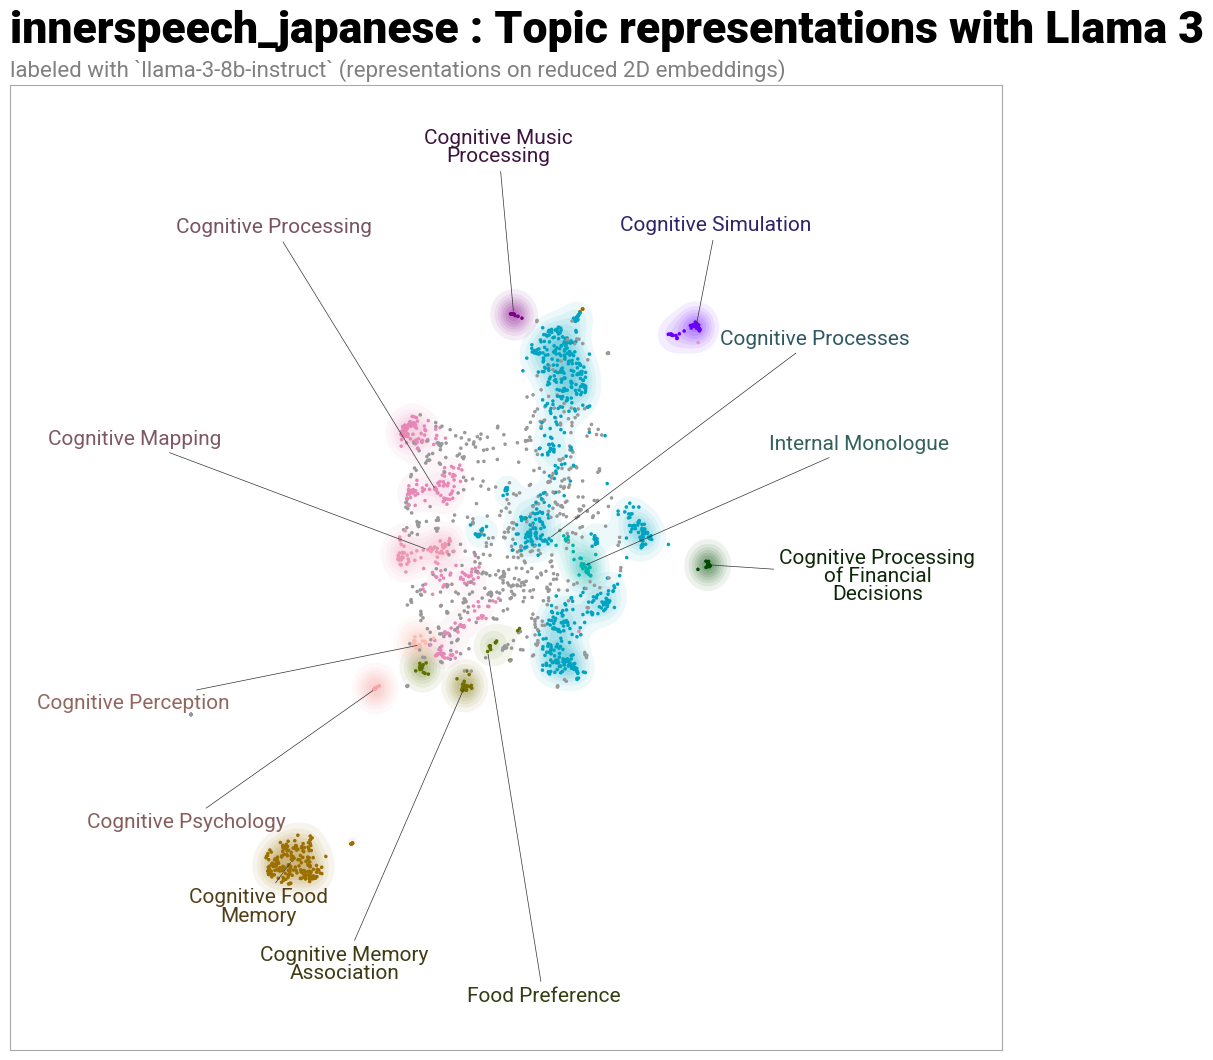

In [67]:
# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{dataset} : Topic representations with Llama 3",
   sub_title="labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);

In [70]:

hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=.8)
hierarchy_vis